# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [ ]:
# libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tfs
import torchvision.transforms.functional as F
import numpy as np
from PIL import Image
import os
import json
import random
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks

### Process Endovis 2018 Dataset

In [6]:
class Endovis2018Dataset(Dataset):
    def __init__(self, img_dir, label_dir, json_path, transform=None):
        self.classes = json.load(open(json_path))
        self.img_dir = img_dir
        self.transform = transform
        
        # data list
        self.image_list = []
        for dir in img_dir:
            for frame in os.listdir(dir):
                if frame.endswith('.png'):
                    img_path = os.path.join(dir, frame)
                    self.image_list.append(img_path)
        # label list       
        self.label_list = []
        for dir in label_dir:
            for frame in os.listdir(dir):
                if frame.endswith('.png'):
                    img_path = os.path.join(dir, frame)
                    self.label_list.append(img_path)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # get image and labels
        image_path = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        label_path = self.label_list[idx]
        label = Image.open(label_path).convert('RGB')
        # apply transforms with random seed so label and data get same transforms (for training)
       
        if self.transform:
            image, label = self.transform(image,label)
            
        return image, label

def calculate_mean_std(dataloader):
    
    n_samples = 0
    channel_sum = torch.zeros(3)
    channel_squared_sum = torch.zeros(3)

    print("Calculating mean and standard deviation...")
    for images, _ in tqdm(dataloader):  # We only need images, not labels
        # print(images.shape)
        images = images.view(images.size(0), images.size(1), -1)  # Flatten height and width
        # print(images.shape)
        n_samples += images.size(2)*images.size(0)  # Total number of pixels per channel
        channel_sum += images.sum(dim=(0, 2))  # Sum over batch and pixels
        channel_squared_sum += (images**2).sum(dim=(0, 2))  # Sum of squares over batch and pixels

    mean = channel_sum / n_samples
    std = torch.sqrt(channel_squared_sum / n_samples - mean**2)
    # Mean: [0.4641706645488739, 0.3407946527004242, 0.3625279366970062], Std: [0.2085169553756714, 0.19439055025577545, 0.20422272384166718]
    return mean.tolist(), std.tolist()

class SegmentationTransform:
    def __init__(self, image_size, mean, std, training):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        self.training = training

    def __call__(self, image, label):
        # Convert to tensors
        image = F.to_tensor(image)
        label = F.to_tensor(label)
        
        #only do these transforms for training
        if self.training:
            # Random Horizontal Flip
            if random.random() > 0.5:
                image = F.hflip(image)
                label = F.hflip(label)

            # Random Vertical Flip
            if random.random() > 0.5:
                image = F.vflip(image)
                label = F.vflip(label)

        # Normalize the image
        image = F.normalize(image, mean=self.mean, std=self.std)

        # Resize image and label
        image = F.resize(image, self.image_size)
        label = F.resize(label, self.image_size)

        return image, label
    
def getDataloaders(batch_size, reduce_factor):
    # paths for data
    cur_dir = os.getcwd()
    data_path = os.path.join(cur_dir, "data")
    json_path = os.path.join(data_path, "labels.json")

    # get training image and label directories from data folder
    sub_dir = [os.path.join(data_path, sub) for sub in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub))]
    img_dir = [os.path.join(sub, 'frames') for sub in sub_dir] # frames is the left_frames folder
    label_dir = [os.path.join(sub, 'labels') for sub in sub_dir]

    train_idx = [0,1,2,3,4,5,7,9,10,12,13] # train seq = 1,3,4,6,7,10,11,12,13,14,16
    val_idx = [6,8,11,14] # val seq = 2,5,9,15, random validation seqs from other papers
    test_idx = [15,16,17,18] # test seq = test_1, test_2. test_3, test_4 (last 4 sequences)

    # get train, validation and test directories separated
    train_img_dir = [img_dir[i] for i in train_idx]
    train_label_dir = [label_dir[i] for i in train_idx]
    val_img_dir = [img_dir[i] for i in val_idx]
    val_label_dir = [label_dir[i] for i in val_idx]
    test_img_dir = [img_dir[i] for i in test_idx]
    test_label_dir = [label_dir[i] for i in test_idx]

    # data augmentation transforms
    test_img = Image.open(os.path.join(img_dir[0], os.listdir(img_dir[0])[0])) # test image
    image_size = test_img.size # size of endovis 2018 images
    reduced_img_size = (int(image_size[0]/reduce_factor),int(image_size[1]/reduce_factor))
    # transforms for training images, test/val images, and labels
    train_transform = SegmentationTransform(
        image_size=(reduced_img_size[0], reduced_img_size[1]),
        mean=(0.464, 0.341, 0.363),
        std=(0.210, 0.194, 0.204),
        training = True
    )
    test_transform = SegmentationTransform(
        image_size=(reduced_img_size[0], reduced_img_size[1]),
        mean=(0.464, 0.341, 0.363),
        std=(0.210, 0.194, 0.204),
        training = False
    )
    # create dataloaders, num_workers = 0 for notebooks
    train_dataset = Endovis2018Dataset(train_img_dir, train_label_dir, json_path, train_transform)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
    val_dataset = Endovis2018Dataset(val_img_dir, val_label_dir, json_path, test_transform)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=0)
    test_dataset = Endovis2018Dataset(test_img_dir, test_label_dir, json_path, test_transform)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=0)

    print("--Data Information--")
    print("Actual Image Size:", image_size)
    print("Reduced Image Size:", reduced_img_size)
    print("Training Set Size:", len(train_dataset))
    print("Validation Set Size:", len(val_dataset))
    print("Test Set Size:", len(test_dataset))
    
    return train_dataloader, val_dataloader, test_dataloader

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (640, 512)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997
Calculating mean and standard deviation...


100%|██████████| 52/52 [02:35<00:00,  2.98s/it]


Mean: [0.000812893733382225, -0.0010584637057036161, -0.0023144821170717478], Std: [0.9929379224777222, 1.0020129680633545, 1.001092553138733]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0508368..2.9937897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0345845..3.0216906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0574477..2.9959831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.866463..3.3925085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8099905..3.396503].


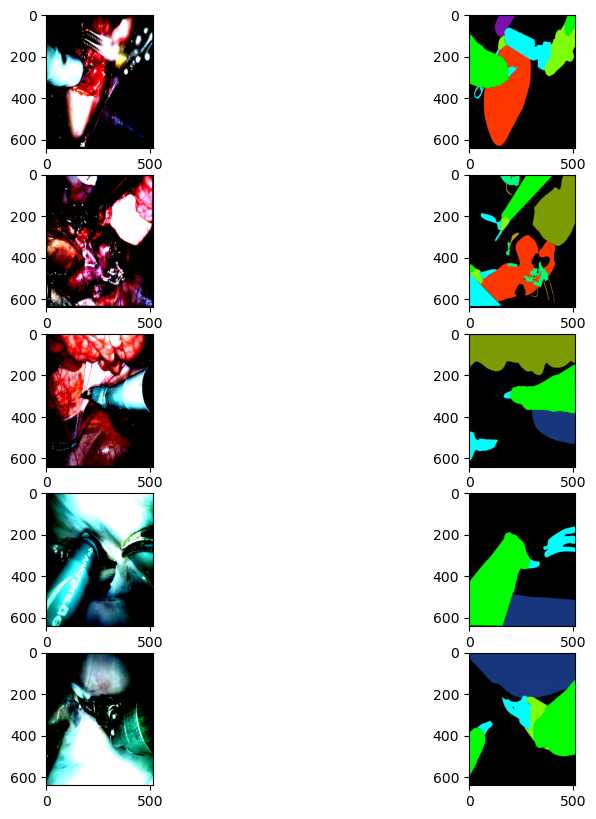

In [ ]:
# get dataloaders and display test images
batch_size = 32
reduce_factor = 2 # how much to reduce image size by before training
train_dataloader, val_dataloader, test_dataloader = getDataloaders(batch_size, reduce_factor)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(5):  # Flatten the 2D array of axes
    axes[0,i].imshow(images[i].permute(1, 2, 0))  # Display the image in grayscale
    axes[1,i].imshow(labels[i].permute(1, 2, 0))
    
plt.tight_layout
plt.show()